In [29]:
import json
import math
import os.path
import sys
from collections import Counter, defaultdict
import operator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import spacy
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from IPython.display import HTML, Image, clear_output, display
from torch.autograd import Variable
from tqdm import tqdm

sys.path.append('..')

In [30]:
import config
import data
import model_IG
import utils

In [31]:
%reload_ext autoreload
%autoreload 2

## Paths, parameters, etc.

In [32]:
# which GPU device to use?
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# path to pretrained model
MODEL_FILE = '../logs/2017-08-04_00.55.19.pth'

# TSV file to write attributions 
ATTRS_TSV = '../results/attrs.tsv'

# HTML file to pretty display attributions
# The folder containing the images is assumed to be named "val" 
# and be in the same directory as this HTML
ATTRS_HTML = '../results/attrs.html'
# this should be a path relative to the location of attrs.html
IMAGES_DIR = '../data_vqa1.0/val2014/'
NUM_VIZS = 500

# Number of steps in Riemann integral computation for Integrated Gradients
NUM_STEPS = 2000

# Sample size of dataset to use in all computations of this notebooks
MAX_NUM_BATCHES = 10000 

# File (EPS format) for writing the overstability curve
OVERSTABILITY_CURVE_FILE = '../results/overstability.eps'

In [33]:
# Load pretrained model
log = torch.load(MODEL_FILE)
tokens = len(log['vocab']['question']) + 1

net = torch.nn.DataParallel(model_IG.Net(tokens))
net.load_state_dict(log['weights'])

../model_IG.py:95: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(w)
../model_IG.py:91: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.embedding.weight)
../model_IG.py:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(m.weight)


In [34]:
# Load vocabulary
with open(config.vocabulary_path, 'r') as fd:
    vocab_json = json.load(fd)
reverse_vocab_question = dict(
    [(v, k) for k, v in vocab_json['question'].items()])
reverse_vocab_answer = dict([(v, k) for k, v in vocab_json['answer'].items()])

In [35]:
# Extract embedding matrix for question words
question_emb_lookup = log['weights']['module.text.embedding.weight']
embedding = nn.Embedding(
    question_emb_lookup.shape[0], question_emb_lookup.shape[1], padding_idx=0)
embedding.weight.data = question_emb_lookup

In [36]:
# Load validation data
val_loader = data.get_loader(val=True)
LOADER = val_loader
PREFIX = "val"

In [37]:
# Image index dict
reverse_coco_idxs = dict(
    [(v, k) for k, v in val_loader.dataset.coco_id_to_index.items()])

In [38]:
def get_answer(a):
    """ Get the answer that at least 3 turkers have agreed on """
    indices = torch.nonzero(a >= 3)
    if len(indices) == 0:
        return ''
    return '|'.join([reverse_vocab_answer[int(index)] for index in indices])

In [39]:
# Setting up a few items
if not os.path.isdir(os.path.dirname(ATTRS_TSV)):
    os.makedirs(os.path.dirname(ATTRS_TSV))

var_params = {
    'requires_grad': False,
}

# number of batches for the integral summation for computing attributions
num_batches_ig = int(np.ceil(NUM_STEPS/val_loader.batch_size))

## Compute accuracy

In [14]:
# Script to compute attributions for a fixed number of batches
net.eval()
orig_answ = []
orig_accs = []
num_batches = 0
# iterator over the validation dataset
tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
for v, q, a, idx, q_len in tq:
    v = Variable(v.cuda(async=True), **var_params)
    q = Variable(q.cuda(async=True), **var_params)
    a = Variable(a.cuda(async=True), **var_params)
    q_len = Variable(q_len.cuda(async=True), **var_params)

    q_emb = embedding(q)

    out = net(v, q_emb, q_len)
    _, answer = out.data.cpu().max(dim=1)
    orig_answ.append(np.array(answer.view(-1)))

    acc = utils.batch_accuracy(out.data, a.data).cpu()

    orig_accs.append(np.array(acc.view(-1)))

    del v, q, a, idx, q_len, q_emb, acc, out

    if num_batches >= MAX_NUM_BATCHES:
        break
    num_batches += 1
    
orig_answ = list(np.concatenate(orig_answ, axis=0))
orig_accs = list(np.concatenate(orig_accs, axis=0))

val E000:   0% 0/950 [00:00<?, ?it/s]../model_IG.py:140: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = F.softmax(attention)
val E000: 100% 950/950 [01:58<00:00,  8.02it/s]


In [15]:
# Accuracy 
print('Accuracy over', len(orig_accs),'inputs:',np.mean(np.array(orig_accs)))

Accuracy over 121512 inputs: 0.6112985


### Adversarial example on one particular question

In [16]:
# Script to compute attributions for a fixed number of batches
net.eval()
# iterator over the validation dataset
tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
for v, q, a, idx, q_len in tq:
    
    q[3, 1] = vocab_json['question']['spherical']
     
    v = Variable(v.cuda(async=True), **var_params)
    q = Variable(q.cuda(async=True), **var_params)
    a = Variable(a.cuda(async=True), **var_params)
    q_len = Variable(q_len.cuda(async=True), **var_params)

    q_emb = embedding(q)

    out = net(v, q_emb, q_len)
    _, answer = out.data.cpu().max(dim=1)
    
    batch_id = 3
    question = [reverse_vocab_question[int(q[batch_id, i])] for i in range(int(q.shape[1])) if int(q[batch_id, i]) != 0]
    print(' '.join(question))
    print(reverse_vocab_answer[int(answer.view(-1)[3])])
    del v, q, a, idx, q_len, q_emb, out

    break

val E000:   0% 0/950 [00:00<?, ?it/s]../model_IG.py:140: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = F.softmax(attention)


how spherical are the white bricks on either side of the building
very


## Compute attributions
Approx running time: 21 hours on GeForce GTX 1080 Ti (12 GB), Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 64GB RAM

In [12]:
padding_embedding = embedding.weight.data[0, :]


def scale_input(q_emb, num_batches=1):
    """ Create scaled versions of input and stack along batch dimension
    q_emb shape = (q_length, emb_dim)
    """
    num_points = config.batch_size*num_batches
    scale = 1.0/num_points
    step = (q_emb.unsqueeze(0) -
            padding_embedding.unsqueeze(0).unsqueeze(0)) * scale
    ans = torch.cat([torch.add(padding_embedding, step*i)
                     for i in range(num_points)], dim=0)
    return ans, step.squeeze()

In [33]:
def compute_attributions(q_emb, q_len, v, idx, num_batches=5, answer=None):
    """ compute attributions for all examples in a given batch """
    ans = ''
    for batch_i in range(int(q_emb.shape[0])):
        scaled_q_emb, step = scale_input(
            q_emb[batch_i, :, :], num_batches=num_batches)
        diff = 0
        total_grads = 0
        repeated_q_len = (torch.ones([config.batch_size] + list(q_len.shape[1:]), dtype=torch.long).cuda(async=True)*q_len[batch_i])
        repeated_v = (torch.ones([config.batch_size] + list(v.shape[1:])).cuda(async=True)*v[batch_i])
        for j in range(num_batches):
            batch_scaled_q_emb = scaled_q_emb[j*config.batch_size:(
                j+1)*config.batch_size]
            with torch.autograd.set_grad_enabled(True):
                scaled_answer, gradients = net(
                    repeated_v, batch_scaled_q_emb, repeated_q_len, compute_gradient=True, ans_index=int(answer[batch_i]))
            # at this point, shape(gradients) = 128 x 23 x 300
            total_grads += torch.sum(gradients, dim=0)
            if j == 0:
                diff -= scaled_answer[0, answer[batch_i]]
                baseline_softmax = scaled_answer[0, :]
            if j == num_batches - 1:
                diff += scaled_answer[-1, answer[batch_i]]
        del scaled_q_emb, repeated_q_len, repeated_v, batch_scaled_q_emb, gradients
        attributions = torch.sum(total_grads * step, dim=1)
        area = torch.sum(attributions, dim=0)
        #print('--------------------------')
        #print(('diff: ', float(diff)))
        #print(('area: ', float(area)))
        if abs(float(diff) - float(area)) > 0.001:
            print(('WARNING: attribution sanity check not matching up!! Diff = ', abs(
                float(diff) - float(area))))

        predicted_answer = reverse_vocab_answer[int(answer[batch_i])]
        correct_answer = get_answer(a[batch_i, :])
        _, baseline_topk_answers = baseline_softmax.topk(1)
        baseline_topk_answers = ', '.join(
            [reverse_vocab_answer[int(i)] for i in baseline_topk_answers])

        if baseline_topk_answers[0] == predicted_answer:
            attributions = attributions*0

        #print('Predicted answer: ', predicted_answer)
        #print('Baseline top k answers : ', ' | '.join(baseline_topk_answers))
        #print('Prediction is correct?: ', int(acc[batch_i]))
        #print('Image ID: ', val_loader.dataset.coco_ids[int(idx[batch_i])])
        question_attrs = []
        for j, w in enumerate(q[batch_i, :]):
            if int(w) != 0:
                #print(reverse_vocab_question[int(w)], ': ', float(attributions[j]))
                question_attrs.append(
                    '|'.join([str(reverse_vocab_question[int(w)]), str(float(attributions[j]))]))
        tsv_string = ['||'.join(question_attrs), baseline_topk_answers, predicted_answer, correct_answer, str(
            int(acc[batch_i])), str(val_loader.dataset.coco_ids[int(idx[batch_i])])]
        ans += '\t'.join(tsv_string) + '\n'
        del attributions, area
    return ans

In [ ]:
# Script to compute attributions for a fixed number of batches
net.train()
accs = []
num_batches = 0
with open(ATTRS_TSV, 'a') as outf:
    # iterator over the validation dataset
    tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
    for v, q, a, idx, q_len in tq:
        if num_batches < 949:
            num_batches += 1
            continue

        v = Variable(v.cuda(async=True), **var_params)
        q = Variable(q.cuda(async=True), **var_params)
        a = Variable(a.cuda(async=True), **var_params)
        q_len = Variable(q_len.cuda(async=True), **var_params)

        q_emb = embedding(q)

        out = net(v, q_emb, q_len)

        acc = utils.batch_accuracy(out.data, a.data).cpu()

        _, answer = out.data.cpu().max(dim=1)

        attrs_tsv_string = compute_attributions(
            q_emb, q_len, v, idx, num_batches=num_batches_ig, answer=answer)

        outf.write(attrs_tsv_string)
        outf.flush()

        accs.append(np.array(acc.view(-1)))
        
        del v, q, a, idx, q_len, q_emb, acc, out, answer

        if num_batches >= MAX_NUM_BATCHES:
            break
        num_batches += 1

accs = list(np.concatenate(accs, axis=0))

## Visualization

In [15]:
def visualize_attrs(tokens, attrs):
    html_text = ""
    for i, tok in enumerate(tokens):
        r, g, b = get_color(attrs[i])
        html_text += " <strong><span style='size:16;color:rgb(%d,%d,%d)'>%s</span></strong>" % (
            r, g, b, tok)
    return html_text


def get_latex(tokens, attrs):
    ans = ""
    for i, tok in enumerate(tokens):
        [r, g, b] = [w/256.0 for w in get_color(attrs[i])]
        ans += " {\color[rgb]{%f,%f,%f}%s}" % (r, g, b, tok)
    return ans


def normalize_attrs(attrs):
    """ normalize attributions to between -1 and 1 """
    bound = max(abs(attrs.max()), abs(attrs.min()))
    return attrs/bound


def get_color(attr):
    """ attr is assumed to be between -1 and 1 """
    if attr > 0:
        return int(128*attr) + 127, 128 - int(64*attr), 128 - int(64*attr)
    return 128 + int(64*attr), 128 + int(64*attr), int(-128*attr) + 127

In [51]:
def make_visualization_html(tsv_filename, html_filename, num=500):
    html_str = '<head><link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css" integrity="sha384-Gn5384xqQ1aoWXA+058RXPxPg6fy4IWvTNh0E263XmFcJlSAwiGgFAW/dAiS6JXm" crossorigin="anonymous"></head>'
    html_str += '<body> <div class="container"> <h1> Visualizations of the attributions for the Visual QA network</h1>'
    html_str += '<ul class="text-info"><li>Red indicates high values, blue and gray indicates low values </li><li> A green (or red) arrow before the question indicates whether the network got the answer right (or wrong)</li></ul><br>'
    with open(tsv_filename) as f, open(html_filename, 'w') as outf:
        html_str += '<div class="container">'
        outf.write(html_str)
        counter = 0
        for line in f:
            if counter > num:
                break
            counter += 1
            line = line.strip()
            question_attrs, baseline_topk_answers, predicted_answer, correct_answer, is_correct, image_id = line.split(
                '\t')
            question_tokens = []
            attrs = []
            for word_attr in question_attrs.split('||'):
                word, attr = word_attr.split('|')
                question_tokens.append(word)
                attrs.append(float(attr))
            html_str = visualize_attrs(
                question_tokens, normalize_attrs(np.array(attrs)))

            if is_correct == '1':
                html_str = '<span class="text-success font-weight-bold">--></span> ' + html_str
            else:
                html_str = '<span class="text-danger font-weight-bold">--></span> ' + html_str
            html_str += '<br>(prediction, ground truth) = (' + predicted_answer + ', ' + correct_answer + ')'
            html_str += '<br>top answers in baseline (empty question): ' + baseline_topk_answers
            html_str += '<br>image ID: ' + str(image_id)
            html_str += '<br><img src="' + IMAGES_DIR + 'COCO_val2014_' + '0' * \
                (12 - len(str(image_id))) + str(image_id) + \
                '.jpg" width="256" height="256"></img><br><hr><br>'
            outf.write(html_str + '\n')
        outf.write('</div></body>')

In [52]:
make_visualization_html(tsv_filename = ATTRS_TSV, 
                       html_filename = ATTRS_HTML,
                       num=NUM_VIZS)

## Attack by prefixing sentences

In [12]:
def question_concatenation_accuracy(net, phrase, suffix=False):
    """ compute accuracy when phrases are prefixed/suffixed """
    net.eval()
    
    prefix = []
    for word in phrase.split():
        prefix.append(vocab_json['question'][word])
    prefix = torch.LongTensor(prefix) 
    prefix = prefix.unsqueeze(0).repeat(config.batch_size,1)
    accs = []
    num_batches = 0
    # iterator over the validation dataset
    tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
    for v, q, a, idx, q_len in tq:
        curr_batch_size = int(q.shape[0])
        if not suffix:
            q = torch.cat([prefix[:curr_batch_size], q], dim=1)[:,:23] ## 23 because question_length is configured to cap at 23
        else:
            for i in range(curr_batch_size):
                if int(q_len[i]) < 23:
                    curr_prefix_len = min(prefix.shape[1], (23 - int(q_len[i])))
                    q[i, int(q_len[i]):int(q_len[i]) + curr_prefix_len] = prefix[0, :curr_prefix_len]
        q = q.contiguous()
        
        q_len = q_len + prefix.shape[1]
        q_len = torch.min(q_len, torch.LongTensor([23]).expand_as(q_len))


        v = Variable(v.cuda(async=True), **var_params)
        q = Variable(q.cuda(async=True), **var_params)
        a = Variable(a.cuda(async=True), **var_params)
        q_len = Variable(q_len.cuda(async=True), **var_params)

        q_emb = embedding(q)

        out = net(v, q_emb, q_len)

        acc = utils.batch_accuracy(out.data, a.data).cpu()

        accs.append(np.array(acc.view(-1)))
        del v, q, a, idx, q_len, q_emb, acc, out

        if num_batches >= MAX_NUM_BATCHES:
            break
        num_batches += 1

    accs = list(np.concatenate(accs, axis=0))
    return accs

In [13]:
PHRASES = [
    'in not a lot of words',
    'in not many words',
    'what is the answer to',
    'tell me',
    'answer this',
    'answer this for me'
]

prefix_attack_accs = []
for phrase in PHRASES:
    prefix_attack_accs.append(question_concatenation_accuracy(net, phrase))

val E000:   0% 0/950 [00:00<?, ?it/s]../model_IG.py:140: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = F.softmax(attention)
val E000: 100% 950/950 [07:41<00:00,  2.06it/s]
val E000: 100% 950/950 [02:34<00:00,  6.14it/s]
val E000: 100% 950/950 [02:04<00:00,  7.65it/s]
val E000: 100% 950/950 [01:58<00:00,  8.01it/s]
val E000: 100% 950/950 [02:02<00:00,  7.75it/s]
val E000: 100% 950/950 [02:01<00:00,  7.80it/s]
val E000: 100% 950/950 [02:02<00:00,  7.74it/s]
val E000: 100% 950/950 [01:59<00:00,  7.94it/s]
val E000: 100% 950/950 [02:01<00:00,  7.82it/s]
val E000: 100% 950/950 [02:00<00:00,  7.91it/s]
val E000: 100% 950/950 [02:02<00:00,  7.72it/s]
val E000: 100% 950/950 [01:59<00:00,  7.95it/s]


In [40]:
updated_prefix_attack_accs = []
for prefix_attack in prefix_attack_accs:
    updated_prefix_attack_accs.append(np.min([orig_accs, prefix_attack], axis=0))

df = pd.DataFrame([w for w in zip(PHRASES, np.mean(updated_prefix_attack_accs, axis=1))], columns=['Attack', 'Prefix'])
df

,Attack,Prefix
0,in not a lot of words,0.355404
1,in not many words,0.324566
2,what is the answer to,0.317257
3,tell me,0.513202
4,answer this,0.557099
5,answer this for me,0.498038


In [60]:
df['accuracy'] = df['accuracy'].apply(lambda x: str(np.round(100 * x, 1))+'%')
print(df.to_latex(index=False, header=True, escape=True))

\begin{tabular}{ll}
\toprule
         prefix phrase & accuracy \\
\midrule
 in not a lot of words &    35.5% \\
     in not many words &    32.5% \\
 what is the answer to &    31.7% \\
               tell me &    51.3% \\
           answer this &    55.7% \\
    answer this for me &    49.8% \\
\bottomrule
\end{tabular}



In [41]:
print("Union of the first three phrase attacks:", np.round(100*np.mean(np.min(updated_prefix_attack_accs[:3], axis=0)), 1))
print("Union of the bottom three phrase attacks:", np.round(100*np.mean(np.min(updated_prefix_attack_accs[3:], axis=0)), 1))

Union of the first three phrase attacks: 19.0
Union of the bottom three phrase attacks: 46.9


### Prefix the question itself

In [63]:
net.eval()
repeat_question_accs = []
num_batches = 0
# iterator over the validation dataset
tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
for v, q, a, idx, q_len in tq:
    curr_batch_size = int(q.shape[0])
    old_q = q.clone()
    for i in range(curr_batch_size):
        q_leni = int(q_len[i])
        q[i, q_leni:2*q_leni] = q[i,:(q_leni if 23-2*q_leni > 0 else 23-q_leni)] ## 23 because question_length is configured to cap at 23
    q = q.contiguous()

    q_len = 2*q_len
    q_len = torch.min(q_len, torch.LongTensor([23]).expand_as(q_len))


    v = Variable(v.cuda(async=True), **var_params)
    q = Variable(q.cuda(async=True), **var_params)
    a = Variable(a.cuda(async=True), **var_params)
    q_len = Variable(q_len.cuda(async=True), **var_params)

    q_emb = embedding(q)

    out = net(v, q_emb, q_len)

    acc = utils.batch_accuracy(out.data, a.data).cpu()

    repeat_question_accs.append(np.array(acc.view(-1)))
    del v, q, a, idx, q_len, q_emb, acc, out, old_q

    if num_batches >= MAX_NUM_BATCHES:
        break
    num_batches += 1

repeat_question_accs = list(np.concatenate(repeat_question_accs, axis=0))


val E000:   0% 0/950 [00:00<?, ?it/s]
../model_IG.py:140: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = F.softmax(attention)
val E000: 100% 950/950 [13:07<00:00,  1.21it/s]


In [64]:
print("Accuracy when question is prefixed to itself:",np.mean(np.min([orig_accs, repeat_question_accs], axis=0)))

Accuracy when question is prefixed to itself: 0.56051666


## Overstability analysis

In [68]:
counts_list = []
top_k = 1
with open(ATTRS_TSV) as f:
    for line in f:
        line = line.strip()
        question_attrs, baseline_answer, predicted_answer, _, _, _ = line.split('\t')
        if baseline_answer == predicted_answer:
            continue
        question_tokens = []
        attrs = []
        for word_attr in question_attrs.split('||'): 
            word, attr = word_attr.split('|')
            question_tokens.append(word)
            attrs.append(float(attr))
        k = min(top_k, len(question_tokens))
        # get top k words by attribution 
        counts_list.extend([question_tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])
counts_list = [w for w, _ in Counter(counts_list).most_common(len(counts_list))]

In [69]:
print(counts_list[:20])

['color', 'many', 'what', 'how', 'doing', 'or', 'where', 'there', 'on', 'is', 'animal', 'room', 'sport', 'number', 'who', 'holding', 'a', 'are', 'which', 'time']


In [ ]:
curve_data = {}
question_lengths = {}
all_accs = []
for K in np.append(0, np.unique(np.floor(np.geomspace(1, len(Counter(counts_list)), 25)))):
    # take K most top attributed words
    if K in curve_data:
        continue
    #whitelist = set([vocab_json['question'][w] for w, c in Counter(counts_list).most_common(int(K))])
    whitelist = set([vocab_json['question'][w] for w in counts_list[:int(K)]]) if K > 0 else set()
    print(len(whitelist))
    accs = []
    num_batches = 0
    avg_question_length_orig = 0
    avg_question_length_new = 0
    num_questions = 0
    # iterator over the validation dataset
    tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
    for v, q, a, idx, q_len in tq:

        old_q = np.asarray(q).copy()
        old_q_len = np.asarray(q_len).copy()

        new_q = np.zeros([config.batch_size, 23])
        curr_batch_size = int(q.shape[0])
        for batch_i in range(curr_batch_size):
            len_counter = 0
            avg_question_length_orig += int(q_len[batch_i])
            for word_i, w in enumerate(q[batch_i,:int(q_len[batch_i])]):
                if int(w) in whitelist:
                    new_q[batch_i, len_counter] = int(w)
                    len_counter += 1
            if len_counter == 0:
                len_counter = 1
            avg_question_length_new += int(len_counter)
            num_questions += 1
            q_len[batch_i] = len_counter
        q_len, sorted_idxs = torch.sort(q_len, descending=True)
        new_q = new_q[sorted_idxs, :]
        idx = idx[sorted_idxs]
        v = v[sorted_idxs,:,:,:]
        a = a[sorted_idxs, :]
        old_q = old_q[sorted_idxs, :]
        old_q_len = old_q_len[sorted_idxs]
        q = torch.LongTensor(new_q)

        v = Variable(v.cuda(async=True), **var_params)
        q = Variable(q.cuda(async=True), **var_params)
        a = Variable(a.cuda(async=True), **var_params)
        q_len = Variable(q_len.cuda(async=True), **var_params)

        q_emb = embedding(q)

        out = net(v, q_emb, q_len)

        acc = utils.batch_accuracy(out.data, a.data).cpu()

        accs.append(np.array(acc.view(-1)))
        del v, q, a, idx, q_len, q_emb, acc, out, old_q, sorted_idxs, old_q_len, new_q

        if num_batches >= MAX_NUM_BATCHES:
            break
        num_batches += 1

    accs = list(np.concatenate(accs, axis=0))
    print("avg question length orig: ", float(avg_question_length_orig)/num_questions)
    print("avg question length new: ", float(avg_question_length_new)/num_questions)
    print("accuracy for ", K, " is", np.mean(accs))
    curve_data[K] = np.mean(accs)
    question_lengths[K] = float(avg_question_length_new)/num_questions


val E000:   0% 0/950 [00:00<?, ?it/s]

0


../model_IG.py:140: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = F.softmax(attention)

val E000:   0% 1/950 [00:01<29:09,  1.84s/it]
val E000: 100% 950/950 [10:52<00:00,  1.46it/s]
val E000:   0% 0/950 [00:00<?, ?it/s]

avg question length orig:  6.205675159655014
avg question length new:  1.0
accuracy for  0.0  is 0.27075595
1


val E000:  60% 569/950 [07:52<05:16,  1.20it/s]

In [ ]:
len(Counter(counts_list))

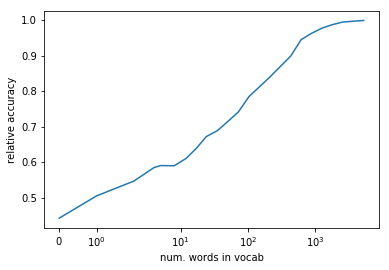

/scratch/pramodkm/acl18/vqa/overstability.eps


In [73]:
plt.plot(curve_data.keys(), np.divide(list(curve_data.values()), np.mean(orig_accs)))
plt.xscale('symlog')
plt.xlabel('num. words in vocab')
plt.ylabel('relative accuracy')
plt.savefig(OVERSTABILITY_CURVE_FILE, format='eps')
plt.savefig(OVERSTABILITY_CURVE_FILE.replace('eps','png'), format='png')
plt.show()
print(OVERSTABILITY_CURVE_FILE)

In [75]:
curve_data

{0.0: 0.27075595,
 1.0: 0.30899417,
 2.0: 0.3344501,
 4.0: 0.35775974,
 5.0: 0.36112317,
 8.0: 0.3608162,
 12.0: 0.37342733,
 17.0: 0.39057213,
 24.0: 0.41096434,
 35.0: 0.4209913,
 50.0: 0.4367396,
 72.0: 0.453226,
 104.0: 0.47987276,
 148.0: 0.49637648,
 212.0: 0.513272,
 304.0: 0.53144467,
 434.0: 0.5493564,
 621.0: 0.5776278,
 888.0: 0.58858794,
 1270.0: 0.5974118,
 1815.0: 0.603519,
 2595.0: 0.607935,
 3710.0: 0.60930693,
 5305.0: 0.6106871}

## Subject ablation attack

In [23]:
NUM_REPLACEMENT_NOUNS = 10
nlp = spacy.load('en')

In [24]:
combined_attrs = defaultdict(float)
with open(ATTRS_TSV) as f:
    for line in f:
        line = line.strip()
        question_attrs, baseline_answer, predicted_answer, _, _, _ = line.split('\t')
        if baseline_answer == predicted_answer:
            continue
        question_tokens = []
        attrs = []
        for word_attr in question_attrs.split('||'): 
            word, attr = word_attr.split('|')
            combined_attrs[word.strip()] += abs(float(attr))

In [25]:
combined_attrs = sorted(combined_attrs.items(), key=operator.itemgetter(1))
unattributed_words = []
for word, _ in combined_attrs:
    if len(unattributed_words) >= NUM_REPLACEMENT_NOUNS:
        break
    processed_word = nlp(word)
    if len(processed_word) == 1 and processed_word[0].pos_ == 'NOUN':
        unattributed_words.append(word)

In [28]:
print(', '.join(['``' + w + "''" for w in unattributed_words]))

``fits'', ``childhood'', ``copyrights'', ``mornings'', ``disorder'', ``importance'', ``topless'', ``critter'', ``jumper'', ``tweet''


In [ ]:
unchanged_fraction = []

for word_index in range(NUM_REPLACEMENT_NOUNS):
    print(unattributed_words[word_index])
    # Script to compute attributions for a fixed number of batches
    net.eval()
    sa_attack_answ = []
    sa_attack_accs = []
    num_batches = 0
    # iterator over the validation dataset
    tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
    for v, q, a, idx, q_len in tq:
        curr_batch_size = int(q.shape[0])
        for i in range(curr_batch_size):
            string_question = [reverse_vocab_question[int(w)] if int(w) != 0 else '' for w in q[i, :]]
            doc = nlp(' '.join(string_question))
            pos_tags = [d.dep_ for d in doc]
            subject_index = [i for i, t in enumerate(pos_tags) if 'nsubj' in t]
            if len(subject_index) == 0:
                continue
            q[i, subject_index[0]] = vocab_json['question'][unattributed_words[word_index]]

        v = Variable(v.cuda(async=True), **var_params)
        q = Variable(q.cuda(async=True), **var_params)
        a = Variable(a.cuda(async=True), **var_params)
        q_len = Variable(q_len.cuda(async=True), **var_params)

        q_emb = embedding(q)

        out = net(v, q_emb, q_len)

        _, answer = out.data.cpu().max(dim=1)
        sa_attack_answ.append(np.array(answer.view(-1)))

        acc = utils.batch_accuracy(out.data, a.data).cpu()

        sa_attack_accs.append(np.array(acc.view(-1)))

        del v, q, a, idx, q_len, q_emb, acc, out

        if num_batches >= MAX_NUM_BATCHES:
            break
        num_batches += 1

    sa_attack_answ = list(np.concatenate(sa_attack_answ, axis=0))
    sa_attack_accs = list(np.concatenate(sa_attack_accs, axis=0))

    ## Percentage of correct answers that did not change
    correct_indices = np.array(orig_accs) >= 0
    correct_answ = np.array(orig_answ)[correct_indices]
    unchanged_fraction.append(sum(np.equal(np.array(sa_attack_answ)[correct_indices], np.array(orig_answ)[correct_indices]))/len(np.array(orig_answ)[correct_indices]))
    print("Percentage of correct answers that did not change:", np.mean(unchanged_fraction))


val E000:   0% 0/950 [00:00<?, ?it/s]

fits


../model_IG.py:140: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = F.softmax(attention)

val E000:   0% 1/950 [00:03<58:39,  3.71s/it]
val E000:   0% 2/950 [00:05<40:11,  2.54s/it]
val E000:   0% 3/950 [00:06<34:20,  2.18s/it]
val E000:   0% 4/950 [00:07<30:52,  1.96s/it]
val E000: 100% 950/950 [25:11<00:00,  1.59s/it]
val E000:   0% 0/950 [00:00<?, ?it/s]

Percentage of correct answers that did not change: 0.7353347817499506
childhood


val E000: 100% 950/950 [25:50<00:00,  1.63s/it]
val E000:   0% 0/950 [00:00<?, ?it/s]

Percentage of correct answers that did not change: 0.7504855487523866
copyrights


val E000: 100% 950/950 [25:52<00:00,  1.63s/it]
val E000:   0% 0/950 [00:00<?, ?it/s]

Percentage of correct answers that did not change: 0.7591211841903132
mornings


val E000: 100% 950/950 [25:53<00:00,  1.63s/it]
val E000:   0% 0/950 [00:00<?, ?it/s]

Percentage of correct answers that did not change: 0.7593406412535387
disorder


val E000: 100% 950/950 [25:53<00:00,  1.63s/it]
val E000:   0% 0/950 [00:00<?, ?it/s]

Percentage of correct answers that did not change: 0.7624333399170452
importance


val E000: 100% 950/950 [25:47<00:00,  1.63s/it]
val E000:   0% 0/950 [00:00<?, ?it/s]

Percentage of correct answers that did not change: 0.7587124454100556
topless


val E000: 100% 950/950 [25:50<00:00,  1.63s/it]
val E000:   0% 0/950 [00:00<?, ?it/s]

Percentage of correct answers that did not change: 0.7577241048503146
critter


val E000: 100% 950/950 [25:55<00:00,  1.64s/it]
val E000:   0% 0/950 [00:00<?, ?it/s]

Percentage of correct answers that did not change: 0.7594682006715385
jumper


val E000:   8% 80/950 [02:18<25:01,  1.73s/it]]

In [111]:
np.mean(unchanged_fraction)

0.7562767463295806

In [112]:
np.mean(orig_accs)

0.6112985

## Stop word deletion attack (not part of the ACL paper)

In [106]:
STOP_WORDS = """
                show, tell, did,  me, you, your, my, 
                our, are,  is, at, were, this, on, would, 
                and,  for, should,  be, do, I, have, had, 
                the, there, has,  was, we, get, does, a,  
                an,  s,  that,  by,  based, in,  of, bring,
                with, to, from, whole, been,  want, wanted,
                as, than, got, sorted, draw, listed, chart, 
                only
            """
STOP_WORDS = STOP_WORDS.strip().split(', ')
STOP_WORDS = [w.strip() for w in STOP_WORDS]
STOP_WORDS = [vocab_json['question'][w] if w in vocab_json['question'] else 0 for w in STOP_WORDS]
STOP_WORDS = set(STOP_WORDS)

In [108]:
stop_word_accs = []
num_batches = 0
num_questions = 0
# iterator over the validation dataset
tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
for v, q, a, idx, q_len in tq:

    old_q = np.asarray(q).copy()
    old_q_len = np.asarray(q_len).copy()

    new_q = np.zeros([config.batch_size, 23])
    curr_batch_size = int(q.shape[0])
    for batch_i in range(curr_batch_size):
        len_counter = 0
        avg_question_length_orig += int(q_len[batch_i])
        for word_i, w in enumerate(q[batch_i,:int(q_len[batch_i])]):
            if int(w) not in STOP_WORDS:
                new_q[batch_i, len_counter] = int(w)
                len_counter += 1
        if len_counter == 0:
            len_counter = 1
        avg_question_length_new += int(len_counter)
        num_questions += 1
        q_len[batch_i] = len_counter
    q_len, sorted_idxs = torch.sort(q_len, descending=True)
    new_q = new_q[sorted_idxs, :]
    idx = idx[sorted_idxs]
    v = v[sorted_idxs,:,:,:]
    a = a[sorted_idxs, :]
    old_q = old_q[sorted_idxs, :]
    old_q_len = old_q_len[sorted_idxs]
    q = torch.LongTensor(new_q)

    v = Variable(v.cuda(async=True), **var_params)
    q = Variable(q.cuda(async=True), **var_params)
    a = Variable(a.cuda(async=True), **var_params)
    q_len = Variable(q_len.cuda(async=True), **var_params)

    q_emb = embedding(q)

    out = net(v, q_emb, q_len)

    acc = utils.batch_accuracy(out.data, a.data).cpu()

    stop_word_accs.append(np.array(acc.view(-1)))
    del v, q, a, idx, q_len, q_emb, acc, out, old_q, sorted_idxs, old_q_len, new_q

    if num_batches >= MAX_NUM_BATCHES:
        break
    num_batches += 1

stop_word_accs = list(np.concatenate(stop_word_accs, axis=0))




val E000:   0% 0/950 [00:00<?, ?it/s]

../model_IG.py:140: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = F.softmax(attention)


val E000:   0% 1/950 [00:03<48:25,  3.06s/it]

val E000:   0% 2/950 [00:04<34:33,  2.19s/it]

val E000:   0% 3/950 [00:06<34:45,  2.20s/it]

val E000:   0% 4/950 [00:11<44:35,  2.83s/it]

val E000:   1% 5/950 [00:12<40:35,  2.58s/it]

val E000:   1% 6/950 [00:14<38:17,  2.43s/it]

val E000:   1% 7/950 [00:16<36:03,  2.29s/it]

val E000:   1% 8/950 [00:17<35:04,  2.23s/it]

val E000:   1% 9/950 [00:29<51:29,  3.28s/it]

val E000:   1% 10/950 [00:38<1:00:48,  3.88s/it]

val E000:   1% 11/950 [00:49<1:10:01,  4.47s/it]

val E000:   1% 12/950 [00:51<1:07:38,  4.33s/it]

val E000:   1% 13/950 [00:52<1:03:36,  4.07s/it]

val E000:   1% 14/950 [00:53<59:31,  3.82s/it]  

val E000:   2% 15/950 [00:53<55:58,  3.59s/it]

val E000:   2% 16/950 [00:54<52:50,  3.39s/it]

val E000:  

val E000:  31% 295/950 [04:49<10:41,  1.02it/s]

val E000:  31% 296/950 [04:50<10:41,  1.02it/s]

val E000:  31% 297/950 [04:50<10:39,  1.02it/s]

val E000:  31% 298/950 [04:53<10:41,  1.02it/s]

val E000:  31% 299/950 [04:53<10:39,  1.02it/s]

val E000:  32% 300/950 [04:54<10:37,  1.02it/s]

val E000:  32% 301/950 [04:54<10:35,  1.02it/s]

val E000:  32% 302/950 [04:54<10:32,  1.02it/s]

val E000:  32% 303/950 [04:55<10:30,  1.03it/s]

val E000:  32% 304/950 [04:56<10:30,  1.02it/s]

val E000:  32% 305/950 [04:57<10:28,  1.03it/s]

val E000:  32% 306/950 [04:59<10:30,  1.02it/s]

val E000:  32% 307/950 [05:00<10:28,  1.02it/s]

val E000:  32% 308/950 [05:00<10:26,  1.02it/s]

val E000:  33% 309/950 [05:01<10:24,  1.03it/s]

val E000:  33% 310/950 [05:01<10:22,  1.03it/s]

val E000:  33% 311/950 [05:02<10:20,  1.03it/s]

val E000:  33% 312/950 [05:03<10:21,  1.03it/s]

val E000:  33% 313/950 [05:04<10:19,  1.03it/s]

val E000:  33% 314/950 [05:06<10:20,  1.02it/s]

val E000:  33% 315/9

val E000:  62% 591/950 [09:02<05:29,  1.09it/s]

val E000:  62% 592/950 [09:03<05:28,  1.09it/s]

val E000:  62% 593/950 [09:03<05:27,  1.09it/s]

val E000:  63% 594/950 [09:06<05:27,  1.09it/s]

val E000:  63% 595/950 [09:07<05:26,  1.09it/s]

val E000:  63% 596/950 [09:07<05:25,  1.09it/s]

val E000:  63% 597/950 [09:08<05:24,  1.09it/s]

val E000:  63% 598/950 [09:08<05:23,  1.09it/s]

val E000:  63% 599/950 [09:09<05:21,  1.09it/s]

val E000:  63% 600/950 [09:09<05:20,  1.09it/s]

val E000:  63% 601/950 [09:10<05:19,  1.09it/s]

val E000:  63% 602/950 [09:14<05:20,  1.09it/s]

val E000:  63% 603/950 [09:14<05:19,  1.09it/s]

val E000:  64% 604/950 [09:15<05:17,  1.09it/s]

val E000:  64% 605/950 [09:15<05:16,  1.09it/s]

val E000:  64% 606/950 [09:16<05:15,  1.09it/s]

val E000:  64% 607/950 [09:16<05:14,  1.09it/s]

val E000:  64% 608/950 [09:17<05:13,  1.09it/s]

val E000:  64% 609/950 [09:17<05:12,  1.09it/s]

val E000:  64% 610/950 [09:20<05:12,  1.09it/s]

val E000:  64% 611/9

val E000:  93% 887/950 [13:16<00:56,  1.11it/s]

val E000:  93% 888/950 [13:17<00:55,  1.11it/s]

val E000:  94% 889/950 [13:17<00:54,  1.11it/s]

val E000:  94% 890/950 [13:20<00:53,  1.11it/s]

val E000:  94% 891/950 [13:21<00:53,  1.11it/s]

val E000:  94% 892/950 [13:21<00:52,  1.11it/s]

val E000:  94% 893/950 [13:22<00:51,  1.11it/s]

val E000:  94% 894/950 [13:22<00:50,  1.11it/s]

val E000:  94% 895/950 [13:23<00:49,  1.11it/s]

val E000:  94% 896/950 [13:23<00:48,  1.11it/s]

val E000:  94% 897/950 [13:24<00:47,  1.12it/s]

val E000:  95% 898/950 [13:27<00:46,  1.11it/s]

val E000:  95% 899/950 [13:28<00:45,  1.11it/s]

val E000:  95% 900/950 [13:28<00:44,  1.11it/s]

val E000:  95% 901/950 [13:29<00:44,  1.11it/s]

val E000:  95% 902/950 [13:29<00:43,  1.11it/s]

val E000:  95% 903/950 [13:30<00:42,  1.11it/s]

val E000:  95% 904/950 [13:30<00:41,  1.12it/s]

val E000:  95% 905/950 [13:31<00:40,  1.12it/s]

val E000:  95% 906/950 [13:35<00:39,  1.11it/s]

val E000:  95% 907/9

In [109]:
np.mean(stop_word_accs)

0.5209708